# PyData Amsterdam 2019 :: Numba Tutorial Notebook 2 :: CuPy and Numba on the GPU



In the previous notebook, we saw how NumPy and Numba could be used for array math on the CPU.  Array operations are very amenable to execution on a massively parallel GPU.  We will not go into the CUDA programming model too much in this tutorial, but the most important thing to remember is that the GPU hardware is designed for *data parallelism*.  Maximum throughput is achieved when you are computing the same operations on many different elements at once.  

## What is CuPy?

Simply put: [CuPy](https://cupy.chainer.org/) is NumPy, but for the GPU.  [Preferred Networks](https://www.preferred-networks.jp/en/) created CuPy as the GPU backend for their deep learning library, [Chainer](https://chainer.org/), but it also works great as a standalone NumPy-like GPU array library.  If you know NumPy, CuPy is a very easy way to get started on the GPU.

Just like NumPy, CuPy offers 3 basic things:

1. A multidimensional array object, but stored in GPU memory.
2. A ufunc system that follows broadcast rules, but executes in parallel on the GPU.
3. A large library of array functions already implemented with CUDA.

In [1]:
import numpy as np
import cupy as cp

CuPy arrays look just like NumPy arrays:

In [2]:
ary = cp.arange(10).reshape((2,5))
print(repr(ary))
print(ary.dtype)
print(ary.shape)
print(ary.strides)

array([[0, 1, 2, 3, 4],
       [5, 6, 7, 8, 9]])
int64
(2, 5)
(40, 8)


This array is in the GPU memory of the default GPU (device 0).  We can see this by inspecting the special `device` attribute:

In [3]:
ary.device

<CUDA Device 0>

We can move data from the CPU to the GPU using the `cp.asarray()` function:

In [4]:
ary_cpu = np.arange(10)
ary_gpu = cp.asarray(ary_cpu)
print('cpu:', ary_cpu)
print('gpu:', ary_gpu)
print(ary_gpu.device)

cpu: [0 1 2 3 4 5 6 7 8 9]
gpu: [0 1 2 3 4 5 6 7 8 9]
<CUDA Device 0>


Note that when we print the contents of a GPU array, CuPy is copying the data from the GPU back to the CPU so it can print the results.

If we are done with the data on the GPU, we can convert it back to a NumPy array on the CPU with the `cp.asnumpy()` function:

In [5]:
ary_cpu_returned = cp.asnumpy(ary_gpu)
print(repr(ary_cpu_returned))
print(type(ary_cpu_returned))

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
<class 'numpy.ndarray'>


### GPU Array Math

Most of the NumPy methods are supported in CuPy with identical function names and arguments:

In [6]:
print(ary_gpu * 2)
print(cp.exp(-0.5 * ary_gpu**2))
print(cp.linalg.norm(ary_gpu))
print(cp.random.normal(loc=5, scale=2.0, size=10))

[ 0  2  4  6  8 10 12 14 16 18]
[1.00000000e+00 6.06530660e-01 1.35335283e-01 1.11089965e-02
 3.35462628e-04 3.72665317e-06 1.52299797e-08 2.28973485e-11
 1.26641655e-14 2.57675711e-18]
16.881943016134134
[5.901596   9.02172619 4.32145152 2.95635009 7.42016409 4.59754869
 7.35189539 6.13808627 2.28631277 2.11685189]


You may notice a slight pause when you run these functions the first time.  This is because CuPy has to compile the CUDA functions on the fly, and then cache them to disk for reuse in the future.

That's pretty much it!  CuPy is very easy to use and has excellent [documentation](https://docs-cupy.chainer.org/en/stable/overview.html), which you should become familiar with.

Before we get into GPU performance measurement, let's switch gears back to Numba.

## When would I want Numba on the GPU?

Similar to NumPy, Numba can be useful to use with CuPy when you want to:

* Combine several operations together for greater efficiency.
* Implement custom algorithms that are not easily described by combining CuPy functions.

Numba's compiler pipeline for transforming Python functions to machine code can be used to generate CUDA functions which can be used standalone or with CuPy.  There are two basic approaches supported by Numba:

 1. ufuncs/gufuncs (subject of the rest of this notebook)
 2. CUDA Python kernels (subject of next notebook)

## Making new ufuncs for the GPU

Numba has the ability to create compiled ufuncs.  You implement a scalar function of all the inputs, and Numba will figure out the broadcast rules for you.  Generating a ufunc that uses CUDA requires giving an explicit type signature and setting the `target` attribute:

In [7]:
from numba import vectorize

@vectorize(['int64(int64, int64)'], target='cuda')
def add_ufunc(x, y):
    return x + y

In [8]:
a = np.array([1, 2, 3, 4])
b = np.array([10, 20, 30, 40])
b_col = b[:, np.newaxis] # b as column array
c = np.arange(4*4).reshape((4,4))

print('a+b:\n', add_ufunc(a, b))
print()
print('b_col + c:\n', add_ufunc(b_col, c))

a+b:
 [11 22 33 44]

b_col + c:
 [[10 11 12 13]
 [24 25 26 27]
 [38 39 40 41]
 [52 53 54 55]]


A lot of things just happened!  Numba automatically:

 * Compiled a CUDA kernel to execute the ufunc operation in parallel over all the input elements.
 * Allocated GPU memory for the inputs and the output.
 * Copied the input data to the GPU.
 * Executed the CUDA kernel with the correct kernel dimensions given the input sizes.
 * Copied the result back from the GPU to the CPU.
 * Returned the result as a NumPy array on the host.

This is very convenient for testing, but copying data back and forth between the CPU and GPU can be slow and hurt performance.  In the next tutorial notebook, you'll learn about device management, memory allocation, and using CuPy arrays with Numba.

You might be wondering how fast our simple example is on the GPU?  Let's see:

In [9]:
%timeit np.add(b_col, c)   # NumPy on CPU

2.47 µs ± 26.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [10]:
%timeit add_ufunc(b_col, c) # Numba on GPU

1.78 ms ± 17.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


Wow, the GPU is *a lot slower* than the CPU.  What happened??

This is to be expected because we have (deliberately) misused the GPU in several ways in this example:

  * **Our inputs are too small**: the GPU achieves performance through parallelism, operating on thousands of values at once.  Our test inputs have only 4 and 16 integers, respectively.  We need a much larger array to even keep the GPU busy.
  * **Our calculation is too simple**: Sending a calculation to the GPU involves quite a bit of overhead compared to calling a function on the CPU.  If our calculation does not involve enough math operations (often called "arithmetic intensity"), then the GPU will spend most of its time waiting for data to move around.
  * **We copy the data to and from the GPU**: While including the copy time can be realistic for a single function, often we want to run several GPU operations in sequence.  In those cases, it makes sense to send data to the GPU and keep it there until all of our processing is complete.
  * **Our data types are larger than necessary**: Our example uses `int64` when we probably don't need it.  Scalar code using data types that are 32 and 64-bit run basically the same speed on the CPU, but 64-bit data types have a significant performance cost on the GPU.  Basic arithmetic on 64-bit floats can be anywhere from 2x (Pascal-architecture Tesla) to 24x (Maxwell-architecture GeForce) slower than 32-bit floats.  NumPy defaults to 64-bit data types when creating arrays, so it is important to set the `dtype` attribute or use the `ndarray.astype()` method to pick 32-bit types when you need them.
  
  
Given the above, let's try an example that is faster on the GPU:

In [11]:
import math  # Note that for the CUDA target, we need to use the scalar functions from the math module, not NumPy

SQRT_2PI = np.float32((2*math.pi)**0.5)  # Precompute this constant as a float32.  Numba will inline it at compile time.

@vectorize(['float32(float32, float32, float32)'], target='cuda')
def gaussian_pdf(x, mean, sigma):
    '''Compute the value of a Gaussian probability density function at x with given mean and sigma.'''
    return math.exp(-0.5 * ((x - mean) / sigma)**2) / (sigma * SQRT_2PI)

In [12]:
# Evaluate the Gaussian distribution PDF a million times!
x = np.random.uniform(-3, 3, size=1000000).astype(np.float32)
mean = np.float32(0.0)
sigma = np.float32(1.0)

# Quick test
gaussian_pdf(x[0], 0.0, 1.0)

array([0.07411421], dtype=float32)

In [13]:
import scipy.stats # for definition of gaussian distribution
norm_pdf = scipy.stats.norm
%timeit norm_pdf.pdf(x, loc=mean, scale=sigma)

84.6 ms ± 364 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [14]:
%timeit gaussian_pdf(x, mean, sigma)

4.84 ms ± 206 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


That's a pretty large improvement, even including the overhead of copying all the data to and from the GPU.  Ufuncs that use special functions (`exp`, `sin`, `cos`, etc) on large `float32` data sets run especially well on the GPU.

## CUDA Device Functions

Ufuncs are great, but you should not have to cram all of your logic into a single function body. You can also create normal functions that are only called from other functions running on the GPU.  (These are similar to CUDA C functions defined with `__device__`.)

Device functions are created with the `numba.cuda.jit` decorator:

In [15]:
from numba import cuda

@cuda.jit(device=True)
def polar_to_cartesian(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'], target='cuda')
def polar_distance(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian(rho1, theta1)
    x2, y2 = polar_to_cartesian(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

In [16]:
n = 1000000
rho1 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta1 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)
rho2 = np.random.uniform(0.5, 1.5, size=n).astype(np.float32)
theta2 = np.random.uniform(-np.pi, np.pi, size=n).astype(np.float32)

In [17]:
polar_distance(rho1, theta1, rho2, theta2)

array([0.40255588, 2.0411959 , 1.9343528 , ..., 0.6198561 , 1.7985634 ,
       0.92233944], dtype=float32)

Note that the CUDA compiler aggressively inlines device functions, so there is generally no overhead for function calls.  Similarly, the "tuple" returned by `polar_to_cartesian` is not actually created as a Python object, but represented temporarily as a struct, which is then optimized away by the compiler.

We can compare this to doing the same thing on the CPU, still using Numba:

In [20]:
import numba

@numba.jit
def polar_to_cartesian_cpu(rho, theta):
    x = rho * math.cos(theta)
    y = rho * math.sin(theta)
    return x, y  # This is Python, so let's return a tuple

@vectorize(['float32(float32, float32, float32, float32)'])  # default target is CPU
def polar_distance_cpu(rho1, theta1, rho2, theta2):
    x1, y1 = polar_to_cartesian_cpu(rho1, theta1)
    x2, y2 = polar_to_cartesian_cpu(rho2, theta2)
    
    return ((x1 - x2)**2 + (y1 - y2)**2)**0.5

np.testing.assert_allclose(polar_distance(rho1, theta1, rho2, theta2),
                           polar_distance_cpu(rho1, theta1, rho2, theta2),
                           rtol=1e-7, atol=5e-7)

In [21]:
%timeit polar_distance_cpu(rho1, theta1, rho2, theta2)
%timeit polar_distance(rho1, theta1, rho2, theta2)

31.5 ms ± 565 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
9.44 ms ± 139 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Not a bad speedup, and we're still doing quite a few GPU memory allocations and data copies.

## Allowed Python on the GPU

Compared to Numba on the CPU (which is already limited), Numba on the GPU has more limitations.  Supported Python includes:

* `if`/`elif`/`else`
* `while` and `for` loops
* Basic math operators
* Selected functions from the `math` and `cmath` modules
* Tuples

See [the Numba manual](http://numba.pydata.org/numba-doc/latest/cuda/cudapysupported.html) for more details.

# Exercise

Let's build a "zero suppression" function.  A common operation when working with waveforms is to force all samples values below a certain absolute magnitude to be zero, as a way to eliminate low amplitude noise.  Let's make some sample data:

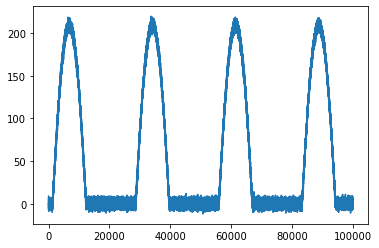

In [22]:
# Hacking up a noisy pulse train
%matplotlib inline
from matplotlib import pyplot as plt

n = 100000
noise = np.random.normal(size=n) * 3
pulses = np.maximum(np.sin(np.arange(n) / (n / 23)) - 0.3, 0.0)
waveform = ((pulses * 300) + noise).astype(np.int16)
plt.plot(waveform)

Now try filling in body of this ufunc:

In [26]:
@vectorize(['int16(int16, int16)'], target='cuda')
def zero_suppress(waveform_value, threshold):
    ### Replace this implementation with yours
    if waveform_value < threshold:
        waveform_value = 0
    ###
    return waveform_value

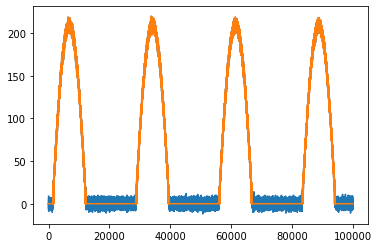

In [28]:
# the noise on the baseline should disappear when zero_suppress is implemented properly
plt.plot(waveform)
plt.plot(zero_suppress(waveform, 15.0))